# Part II: Models Building and Model Selection

In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from utils.data_processing_utils import scale_numeric_columns
from utils.grid_search_utils import *
from utils.plot_utils import *
from utils.evaluation_metrics_utils import *

from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
# set path for loading data
DATA_PATH = 'data/'
DIABETIC_DATA = 'diabetic_data_final.csv'

In [3]:
# load data
df = pd.read_csv(DATA_PATH+DIABETIC_DATA)

In [4]:
# seperate the label from dataset and store the label and the rest to variables.
y = df['readmitted']
X = df.drop('readmitted', axis=1)

'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses' are the only numeric columns. Thus, these columns need to be re-scaled later beforing feeding the data to classifiers.

# Spliting data into train and test sets

In [5]:
# split the data into train and test sets with an 8:2 ratio.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Principal Component Analysis

In the previous part, I pre-processed the entire data set. However, the data set still contains 103 features. To decrease the size of the feature space, I used PCA to reduce the dimensions.

In [6]:
print("Data set shape: "+str(df.shape))

Data set shape: (98053, 103)


In [7]:
from sklearn.decomposition import PCA

In [8]:
# instantiate PCA object
pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

From the diagram below, we can see that the first 20 and 40 principal components explained 98% - 100% of explained variance already. Anything number between 20 and 40 of components will be more than sufficient to represent the entire dataset. Thus, I picked the number inbetween, 30, and project the dataset onto the first 30 principal components.

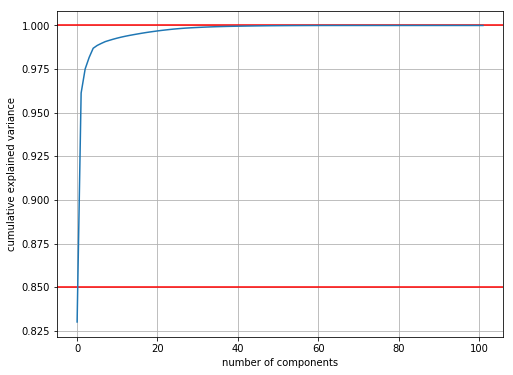

In [9]:
plot_explained_variance_vs_components(pca.explained_variance_ratio_)
plt.show()

# Model Selection

In model selection part, four classifiers, logistic regression, random forest, Gaussian NB and a custom ensemble classifier are used. The reason I implemented the ensemble classifier is to understand and practice how to build one from scratch.

Considering my laptop is not computationally powerful, I used greedy approach to perform grid search for tuning parameters. I changed one parameter at a time and left everything else to default. Optimizing parameter with grid search this way instead trying all the combinations is less computationally demanding.

After getting the results from the grid search, only the parameters that provided similar high accuracy are selected. Otherwise, the accuracy could be lowered with parameters that do not yield similar results.

# Logistic Regression with PCA

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
C = [0.01, 0.03, 0.1, 0.3, 1, 3]
param_grid_lg = {'C': C}
logistic = LogisticRegression(random_state=0)

In [12]:
# set the figure size.
index = 1
plt.figure(figsize=(24, 16))

<Figure size 1728x1152 with 0 Axes>

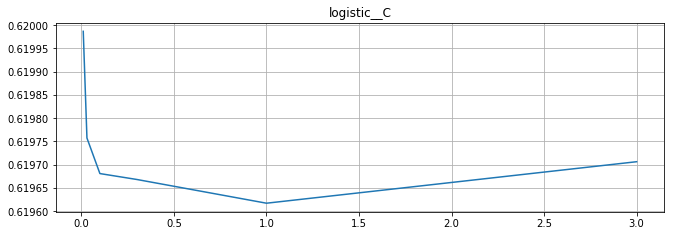

In [13]:
# visualize parameter as a function of accuracy
# to help select the best parameter or the best combination of parameters. 
for param, param_values in dict.items(param_grid_lg):
    evaluate_param(logistic, 'logistic', param, param_values, 30, index, X_train, y_train)
    index += 1
plt.show()

It turns out that the regularization strength is __0.01__ produced the best accuracy.

In [14]:
# narrow the possible best regularization strength to one.
param_grid_lg_pca = {'logistic_pca__C': [0.01]}

Next, let's cross validate our logistic regression classifier using the tuned parameter(s).

In [15]:
pca = PCA(n_components=30)

In [16]:
# set the pipeline.
logistic_pca = LogisticRegression(random_state=0)
pipe = Pipeline([
    ('scale_data', FunctionTransformer(scale_numeric_columns)), 
    ('pca', pca),
    ('logistic_pca', logistic_pca)
])

In [17]:
# instantiate a grid.
grid_logistic_pca = GridSearchCV(pipe, cv=3, param_grid=param_grid_lg_pca, refit=True)
grid_logistic_pca.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale_data', FunctionTransformer(accept_sparse=False,
          func=<function scale_numeric_columns at 0x000000CEB85016A8>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=True)), ('pca', PCA(copy=True, iterated_power='auto', n_component...nalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logistic_pca__C': [0.01]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [18]:
# report validation score and the best parameter configuration.
report(grid_logistic_pca.grid_scores_, 1)

Model with rank: 1
Mean validation score: 0.6200, Standard Deviation: 0.0029
Parameters: {'logistic_pca__C': 0.01}



# Random Forest with PCA

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
# define the parameter grid.
param_grid_rf = {
    "n_estimators": np.arange(200, 600, 100),
    "max_depth": np.arange(1, 30, 10),
    "max_features": np.arange(0.1, 1, 0.5),
    "min_samples_split": [2, 3],
    "min_samples_leaf": [3, 5],
    "max_leaf_nodes": np.arange(100, 500, 100)
}
rf_pca = RandomForestClassifier(random_state=0)

In [21]:
# set the figure size.
index = 1
plt.figure(figsize=(24, 16))

<Figure size 1728x1152 with 0 Axes>

From the figures below, we can see that only when __n_estimators__ is 500 gives the highest accuracy. As far as other parameters, they all produced a lower accuracy than 62%. In this case, 500 for __n_estimators__ is the optimal number and anything else is left as default. 

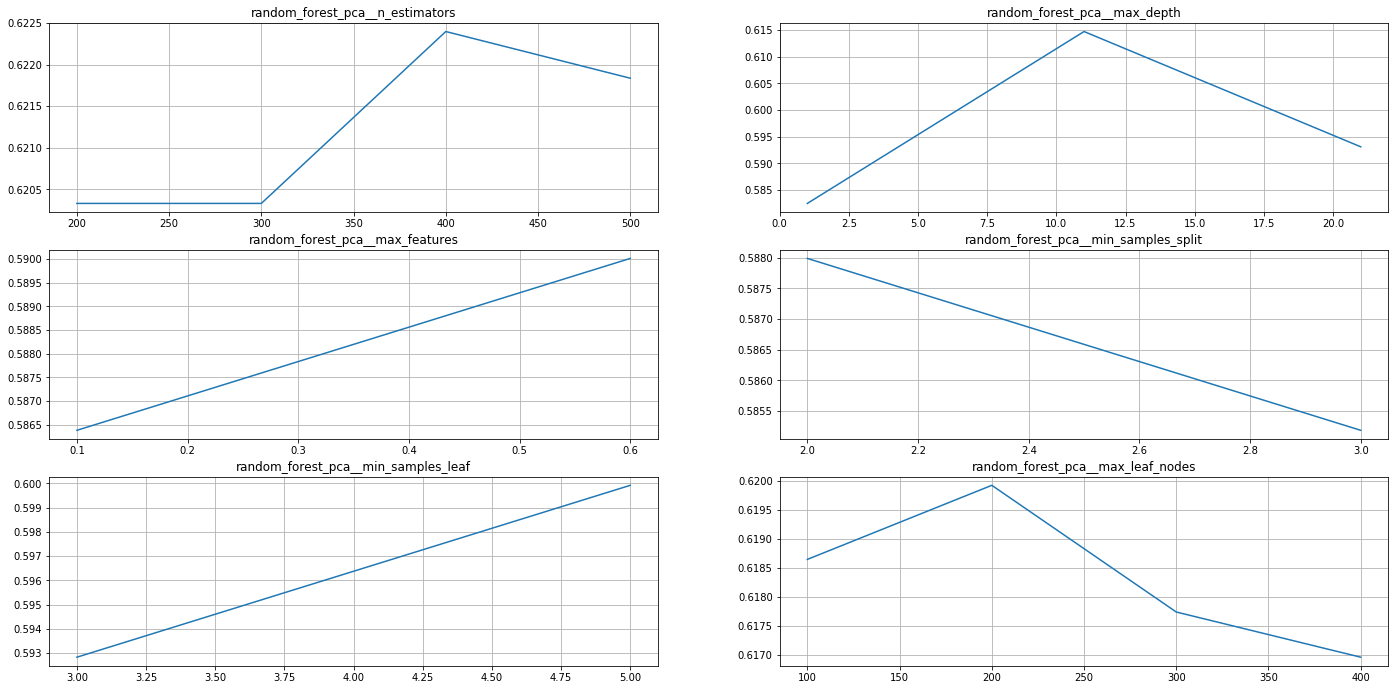

In [22]:
start = time.time()
for param, param_values in dict.items(param_grid_rf):
    evaluate_param(rf_pca, 'random_forest_pca', param, param_values, 30, index, X_train, y_train)
    index += 1
plt.show()

In [23]:
# set n_estimators to 400 and initialize a new random forest object
param_grid_rf_pca = {
    "random_forest_pca__n_estimators": [500]
}
rf_pca = RandomForestClassifier(random_state=0)

In [24]:
# set the pipeline
pca = PCA(n_components=30)
pipe = Pipeline([
    ('scale_data', FunctionTransformer(scale_numeric_columns)), 
    ('pca', pca),
    ('random_forest_pca', rf_pca)
])

In [25]:
grid_rf_pca = GridSearchCV(pipe, cv=3, param_grid=param_grid_rf_pca, refit=True)
grid_rf_pca.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale_data', FunctionTransformer(accept_sparse=False,
          func=<function scale_numeric_columns at 0x000000CEB85016A8>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=True)), ('pca', PCA(copy=True, iterated_power='auto', n_component...estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'random_forest_pca__n_estimators': [500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [26]:
# report results and the best combination of parameters
report(grid_rf_pca.grid_scores_, 1)

Model with rank: 1
Mean validation score: 0.6216, Standard Deviation: 0.0012
Parameters: {'random_forest_pca__n_estimators': 500}



# Gaussian NB

In [27]:
from sklearn.naive_bayes import GaussianNB

In [28]:
nb_clf = GaussianNB()

In [29]:
# set the pipeline
pca = PCA(n_components=30)
pipe_nb = Pipeline([
    ('scale_data', FunctionTransformer(scale_numeric_columns)), 
    ('pca', pca),
    ('nb_pca', nb_clf)
])

In [30]:
# get cross validation score, and evaluation metric is accuracy.
nb_scores = cross_val_score(pipe_nb, X_train, y_train, cv=3)

In [31]:
print("Cross validation score for NB classifier: {:f}".format(nb_scores.mean()))

Cross validation score for NB classifier: 0.600176


# Custom Ensemble

In [32]:
from ensembles.CustomEnsemble import CustomEnsemble

In [33]:
# initialize three classifiers with the best parameters discoverd in the previous steps
clf1 = LogisticRegression(C=3.0, random_state=0)
clf2 = RandomForestClassifier(n_estimators=500, random_state=0)
clf3 = GaussianNB()
clfs = [clf1, clf2, clf3]

In [34]:
# instantiate a ensemble classifier. 
eclf = CustomEnsemble(clfs)

In [35]:
# set the pipline.
pca = PCA(n_components=30)
pipe_eclf = Pipeline([
    ('scale_data', FunctionTransformer(scale_numeric_columns)), 
    ('pca', pca),
    ('eclf', eclf)
])

In [36]:
# get cross validation score, and evaluation metric is accuracy.
eclf_scores = cross_val_score(estimator=pipe_eclf,
                                        X=X_train,
                                        y=y_train,
                                        cv=3,
                                        scoring='accuracy')

In [37]:
print("Cross validation score for ensemble classifier: {:f}".format(eclf_scores.mean()))

Cross validation score for ensemble classifier: 0.621427


# Classification Accuracy Summary

In [38]:
lg_acc = grid_logistic_pca.grid_scores_[0][1]
rf_acc = grid_rf_pca.grid_scores_[0][1]
nb_acc = nb_scores.mean()
eclf_acc = eclf_scores.mean()

clfs = ["Logistic Regression", 'Random Forest', "Gaussian NB", 'Custom Ensemble']
clfs_acc = np.asarray([lg_acc, rf_acc, nb_acc, eclf_acc]) * 100

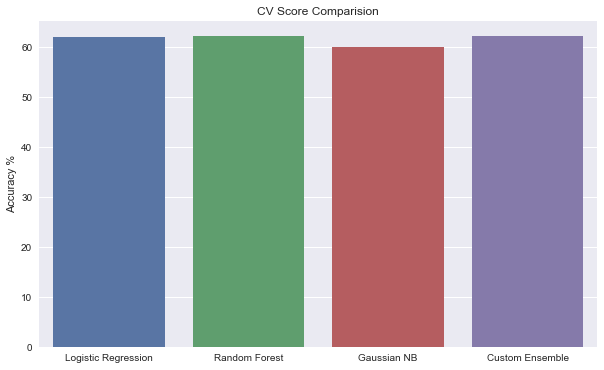

In [39]:
# plot and compare the scores in terms of accuracy.
plt.figure(figsize=(10, 6))
plt_acc = plot_bar_char(clfs, clfs_acc,
                        'CV Score Comparision',
                        'Accuracy %', 1)
plt_acc.show()

As we can see from the bar plot above, logistic regression, random forest and custom ensemble perform perform almost equally well. However, since logistic regression is more efficient and requires less time to train, logistic regression is chosen as the final model.

# Evaluation Metrics

In [40]:
pca = PCA(n_components=30)
logistic = LogisticRegression(C=0.01, random_state=0)
pipe = Pipeline([
    ('scale_data', FunctionTransformer(scale_numeric_columns)), 
    ('pca', pca),
    ('logistic', logistic)
])

In [41]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_pred_prob = pipe.predict_proba(X_test)[:, 1]

In [42]:
print("Final accuracy of logistic regression:", pipe.score(X_test, y_test))

Final accuracy of logistic regression: 0.6165417367803784


# Confusion Matrix

Table that describes the performance of a classification model.

True Positives (TP): correctly predicted that they need to be readmitted.

True Negatives (TN): correctly predicted that they don't need to be readmitted.

False Positives (FP): incorrectly predicted that they need to be readmitted(a "Type I error").

False Negatives (FN): incorrectly predicted that they don't need to be readmitted(a "Type II error").

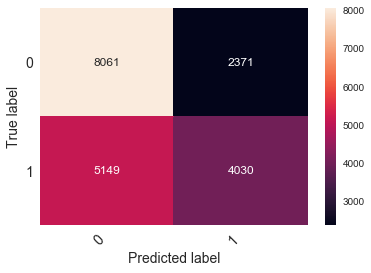

In [43]:
plot_confusion_matrix(y_test, y_pred, class_names=['0', '1'])

In [44]:
from sklearn.metrics import *

Next, let's generate a table for evaluation metrics containing:
* Sensitivity
* pecificity
* F1-Score
* True Predictive Rate
* Negative Predictive Rate

In [45]:
# True negative, false positive, false negative, true positive
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).flatten()
evalutaion_metrics = np.around(compute_performance_measures(tn, fp, fn, tp), 4)
evalutaion_metrics=np.array(evalutaion_metrics).reshape((1, 5))

In [46]:
# display the evaluation metrics table
pd.DataFrame(data=np.asarray(evalutaion_metrics), 
             columns=['Sensitivity','Specificity', 'F1-Score',
                      'True Predictive Rate', 'Negative Predictive Rate'])

,Sensitivity,Specificity,F1-Score,True Predictive Rate,Negative Predictive Rate
0,0.439,0.7727,0.5173,0.6296,0.6102


Since our objective is to increase the sensitivity score, the classification threshold needs to be adjusted.

# ROC curve

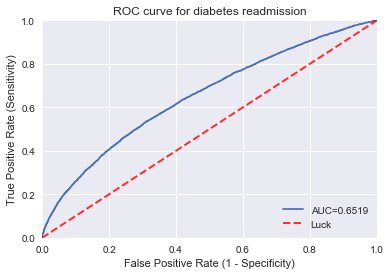

In [47]:
plot_roc_curve(y_test, y_pred_prob)

In [48]:
print("AUC score: {:.4f}".format(roc_auc_score(y_test, y_pred_prob)))

AUC score: 0.6519


# Adjusting the classification threshold

By default, the classification threshold is 0.5. I reduced it to 0.4 in order to increase the sensitivity score. Originally , the sensitivity score is 0.4375

In [49]:
# get all the necessary statistics first.
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

In [50]:
# Set the new threshold to 0.4.
# The new sensitivity score has increase by 30% to 0.7210.
new_threshold = 0.4
print('New threshold: '+str(new_threshold))
print('Adjusted Sensitivity: {:.4f}'.format(tpr[thresholds>=0.4][-1]))
print('Adjusted Specificity: {:.4f}'.format(1-fpr[thresholds>=0.4][-1]))

New threshold: 0.4
Adjusted Sensitivity: 0.7212
Adjusted Specificity: 0.4688


In [51]:
# predict readmission when the threshold is decreased to 0.4
y_pred_adjusted = [1 if prob > new_threshold else 0 for prob in y_pred_prob]

In [52]:
print('Final accuracy after adjusting threshold: {:.4f}'.format(accuracy_score(y_test, y_pred_adjusted)))

Final accuracy after adjusting threshold: 0.5869


# Conclusion

* Using PCA, I was able to reduce the feature space down from 150 features to 30 and maintain 97% plus explained variance.

* In this project, logistic regression, random forest, Gaussian NB and a custom ensemble classifier with three well-tuned classifiers aforementioned are used. All three classifiers except Gaussian NB perform almost equally well, with 62% accuracy and 65% AUC score. However, for its computational efficiency logistic regression is the classifier of choice for this project. 

* After adjusting the classification threshold, the sensitivity score was increased by 30%.

* Domain knowledge in diabetes could provide significant help when performing feature engineering and collecting features.